In [192]:
# Toy-problem for EE Summer School @ IISc - July 2022

# Barrier Functions in Control
# Aditya Hegde, PhD Candidate
# Department of Aerospace Engineering, Indian Insitute of Science, Bangalore

# Application of BLF and CBF to the toy problem

# Double-integrator system: xdot = v, vdot = u
# constraint 1: -c <= v <= c
# constraint 2: x^2 + v^2 <= b^2

# BLF approach: construct V including constraints in the Lyapunov function
#               V = K_P (v^2)/(c^2 - v^2)  +  K_D (x^2 + v^2)/(b^2 - x^2 - v^2)
#               u = - (v + beta)/alpha
#                     (see image below)
# CBF approach: u* = argmin_u (u_r - u)^2
#                    s.t. 2vu <= min(h1, h2 - 2*x*v)

# All the necessary imports
import numpy as np
from scipy.integrate import odeint, solve_ivp

from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True})
import matplotlib.colors as mcolors

from matplotlib.ticker import FormatStrFormatter

from matplotlib.animation import FuncAnimation, writers
plt.style.use('seaborn-pastel')

Writer = writers['ffmpeg']()

### Barrier Lyapunov function

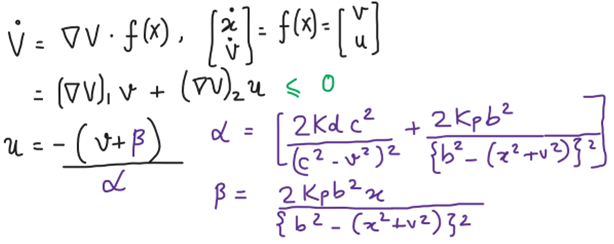

### Control barrier function

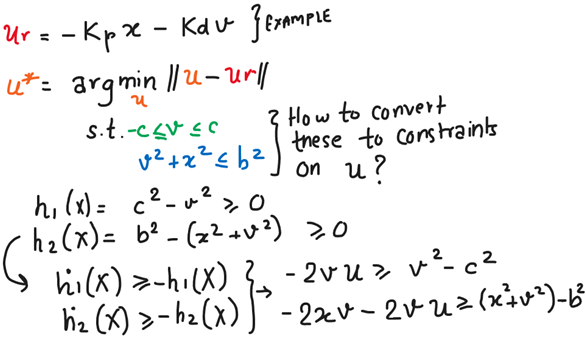
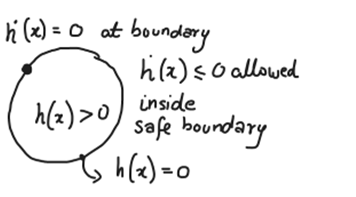

### Barrier Lyapunov function implementation

In [333]:
############## Initial positions and declarations ############################
# initital positions of the agents (3 sets of initial conditions)
x_01 = 3.8
v_01 = 0.4

x_02 = -3.4
v_02 = -1.8

x_03 = -3.6
v_03 = 1.9

# constraint parameters
b = 4
c = 2

# blf parameters (gains)
Kp = 0.1
Kd = 0.5

# PID gains for CBF model
KP = 0.1
KD = 0.2

# time vector for simulation
# final time
tlim = 50

# initial time
t0 = 0

# Number of intervals
steps = 500

# time-step
tstep = tlim/steps

# time vector
t = np.linspace(0, tlim, steps)

# length of the time vector
tlen = np.size(t,0)

# initial conditions arguments to the ode solver
X_01 = [x_01, v_01]
X_02 = [x_02, v_02]
X_03 = [x_03, v_03]
y01 = np.array(X_01)
y02 = np.array(X_02)
y03 = np.array(X_03)

In [1]:
def blf_model(t, y, c, b, Kp, Kd):
    
    """The control input is calculated such that the time derivative of the BLF is negative semi-definite and
    is equal to zero at the equilibrium (0,0).
    See the figure above for the control input details."""
    
    x = y[0]
    v = y[1]
    
    alpha = (2*Kd*(c**2))/((c**2 - v**2)**2) + (2*Kp*(b**2))/((b**2 - (x**2 + v**2))**2)
    beta = (2*Kp*(b**2)*x)/((b**2 - (x**2 + v**2))**2)
    
    xdot = y[1]
    vdot = -(v + beta)/alpha
    
    dydt = np.array([xdot, vdot])
    
    return dydt

In [148]:
# Solve the ODEs (BLF-control)
# initial condition 1
sol1 = solve_ivp(blf_model, (0,tlim), y01, method = 'RK45',  t_eval = t, max_step = 0.01, args = (c, b, Kp, Kd))
y1 = sol1.y.T

# initial condition 2
sol2 = solve_ivp(blf_model, (0,tlim), y02, method = 'RK45',  t_eval = t, max_step = 0.01, args = (c, b, Kp, Kd))
y2 = sol2.y.T

In [149]:
# Retrieve system states (BLF-control)
# initial condition 1
x1_s = y1[:,0]
v1_s = y1[:,1]

# initial condition 2
x2_s = y2[:,0]
v2_s = y2[:,1]

In [180]:
# Retrieve the control inputs (BLF-control)

# initial condition 1
ctrlvec1 = np.zeros_like(sol1.t)
# initial condition 2
ctrlvec2 = np.zeros_like(sol2.t)

# initial condition 1
for i in range(y1.shape[0]):
    u_1 = blf_model(sol1.t[i], y1[i,:], c, b, Kp, Kd)
    ctrlvec1[i] = u_1[1]
    
u1 = ctrlvec1

# initial condition 2
for i in range(y2.shape[0]):
    u_2 = blf_model(sol2.t[i], y2[i,:], c, b, Kp, Kd)
    ctrlvec2[i] = u_2[1]
    
u2 = ctrlvec2

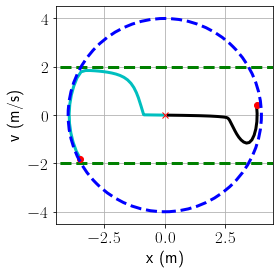

In [171]:
# Plot the phase trajectories (BLF-control)

fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot(x1_s, v1_s, color = 'k', linewidth = 3)
ax.plot(x2_s, v2_s, color = 'c', linewidth = 3)
ax.plot([-5,5], [2,2], 'g--', linewidth = 3)
ax.plot([-5,5], [-2,-2], 'g--', linewidth = 3)
ax.plot([0], [0], 'rx', linewidth = 3, zorder = 6)
ax.plot([x_01], [v_01], 'ro', linewidth = 3)
ax.plot([x_02], [v_02], 'ro', linewidth = 3)
circ_lim = plt.Circle([0,0], b, color='b',fill = False, linestyle = '--', linewidth = 3, zorder = 5)
ax.add_artist(circ_lim)
plt.xlim((-4.5,4.5))
plt.ylim((-4.5,4.5))
ax.set_aspect(1)
plt.xlabel('x (m)', fontsize = 17)
plt.ylabel('v (m/s)',  fontsize = 17)
ax.tick_params(labelsize = 17)
plt.grid(True)
plt.savefig("BLF-constrain.png",bbox_inches='tight', pad_inches = 0.1)
plt.show()

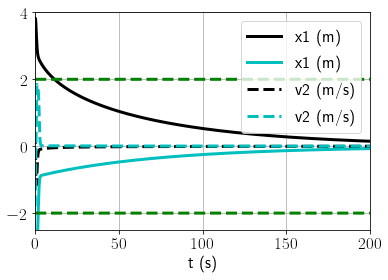

In [188]:
# Plot the system states (BLF-control)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(sol.t, x1_s, 'k', linewidth = 3, label = 'x1 (m)')
ax2.plot(sol.t, x2_s, 'c', linewidth = 3, label = 'x1 (m)')
ax2.plot(sol.t, v1_s, 'k--', linewidth = 3, label = 'v2 (m/s)')
ax2.plot(sol.t, v2_s, 'c--', linewidth = 3, label = 'v2 (m/s)')
ax2.plot(sol.t, 2*np.ones((tlen,1)), 'g--', linewidth = 3)
ax2.plot(sol.t, -2*np.ones((tlen,1)), 'g--', linewidth = 3)
plt.xlim((0,sol.t[-1]))
plt.ylim((-2.5,4))
plt.xlabel('t (s)', fontsize = 17)
ax2.tick_params(labelsize = 17)
plt.grid(True)
plt.legend(fontsize = 17, loc = 1)
plt.savefig("BLF-states.png",bbox_inches='tight', pad_inches = 0.1)
plt.show()

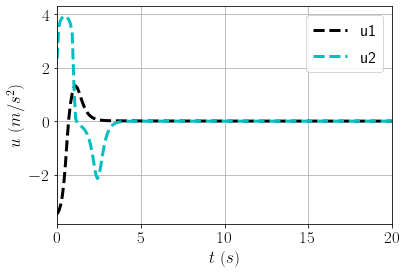

In [187]:
# Plot the control input (BLF-control)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(sol.t, u1, 'k--', linewidth = 3, label = 'u1')
ax3.plot(sol.t, u2, 'c--', linewidth = 3, label = 'u2')
plt.xlim((0,20))
#plt.ylim((-2.5,4))
plt.xlabel('$t~(s)$', fontsize = 17)
plt.ylabel('$u~(m/s^2)$', fontsize = 17)
ax3.tick_params(labelsize = 17)
plt.grid(True)
plt.legend(fontsize = 17, loc = 1)
plt.savefig("BLF-control.png",bbox_inches='tight', pad_inches = 0.1)
plt.show()

### Control barrier function implementation

In [320]:
def convexopt_mod(ur, x, v, c, b):
    
    """The CBF controller uses the cvxopt package. Please see cvxopt documentation for more details."""
    
    # Control limits
    h1 = c**2 - v**2
    h2 = b**2 - (x**2 + v**2)
    
    h = min([h1 - 2*v*ur, h2 - 2*x*v - 2*v*ur])

    #################################################################################
    q_mat = 1.0
    Q = matrix(q_mat)

    #################################################################################
    p_mat = 0.0
    p = matrix(p_mat)

    ################################################################################

    g_mat = 2*v
    G = matrix(g_mat)

    #################################################################################

    h_mat = h
    h = matrix(h_mat)

    ################################################################################

    sol=solvers.qp(Q, p, G, h)
    return sol['x'][0]

In [321]:
def cbf_model(t, y, c, b, KP, KD):
    
    """The CBF overrides a primary PD-controller. See image above for design details."""
    
    x = y[0]
    v = y[1]
    
    # PD primary control
    u = -KP*x - KD*v
    
    # modify the control to meet the constraints
    u_mod =  convexopt_mod(u, x, v, c, b)
    
    # recover the modified control
    u_star = u_mod + u
    
    xdot = y[1]
    vdot = u_star
    
    dydt = np.array([xdot, vdot])
    
    return dydt

In [334]:
# Solve the ODEs (CBF-control)
# initial condition 1
sol3 = solve_ivp(cbf_model, (0,tlim), y01, method = 'RK45',  t_eval = t, max_step = 0.01, args = (c, b, KP, KD))
y3 = sol3.y.T

# initial condition 2
sol4 = solve_ivp(cbf_model, (0,tlim), y02, method = 'RK45',  t_eval = t, max_step = 0.01, args = (c, b, KP, KD))
y4 = sol4.y.T

# initial condition 3
sol5 = solve_ivp(cbf_model, (0,tlim), y03, method = 'RK45',  t_eval = t, max_step = 0.01, args = (c, b, KP, KD))
y5 = sol5.y.T

In [335]:
# Retrieve system states (CBF-control)
# initial condition 1
x3_s = y3[:,0]
v3_s = y3[:,1]

# initial condition 2
x4_s = y4[:,0]
v4_s = y4[:,1]

# initial condition 3
x5_s = y5[:,0]
v5_s = y5[:,1]

In [345]:
# Retrieve the control inputs (CBF-control)

# initial condition 1
ctrlvec3 = np.zeros_like(sol3.t)

# initial condition 2
ctrlvec4 = np.zeros_like(sol4.t)

# initial condition 3
ctrlvec5 = np.zeros_like(sol5.t)

# initial condition 1
for i in range(y3.shape[0]):
    u_3 = cbf_model(sol3.t[i], y3[i,:], c, b, KP, KD)
    ctrlvec3[i] = u_3[1]
    
u3 = ctrlvec3

# initial condition 2
for i in range(y4.shape[0]):
    u_4 = cbf_model(sol4.t[i], y4[i,:], c, b, KP, KD)
    ctrlvec4[i] = u_4[1]
    
u4 = ctrlvec4

# initial condition 3
for i in range(y5.shape[0]):
    u_5 = cbf_model(sol5.t[i], y5[i,:], c, b, KP, KD)
    ctrlvec5[i] = u_5[1]
    
u5 = ctrlvec5

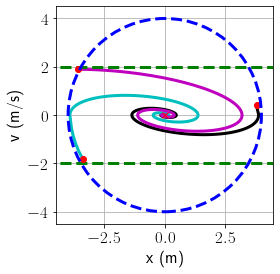

In [338]:
# Plot the phase trajectories (CBF-control)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(x3_s, v3_s, color = 'k', linewidth = 3)
ax4.plot(x4_s, v4_s, color = 'c', linewidth = 3)
ax4.plot(x5_s, v5_s, color = 'm', linewidth = 3)
ax4.plot([-5,5], [2,2], 'g--', linewidth = 3)
ax4.plot([-5,5], [-2,-2], 'g--', linewidth = 3)
ax4.plot([0], [0], 'rx', linewidth = 3, zorder = 6)
ax4.plot([x_01], [v_01], 'ro', linewidth = 3)
ax4.plot([x_02], [v_02], 'ro', linewidth = 3)
ax4.plot([x_03], [v_03], 'ro', linewidth = 3)
circ_lim = plt.Circle([0,0], b, color='b',fill = False, linestyle = '--', linewidth = 3, zorder = 5)
ax4.add_artist(circ_lim)
plt.xlim((-4.5,4.5))
plt.ylim((-4.5,4.5))
ax4.set_aspect(1)
plt.xlabel('x (m)', fontsize = 17)
plt.ylabel('v (m/s)',  fontsize = 17)
ax4.tick_params(labelsize = 17)
plt.grid(True)
plt.savefig("CBF-constrain.png",bbox_inches='tight', pad_inches = 0.1)
plt.show()

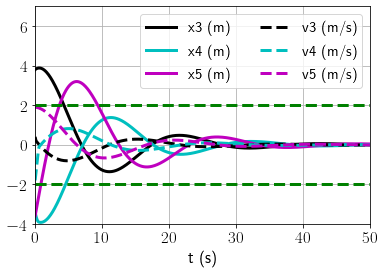

In [340]:
# Plot the system states (CBF-control)
fig5 = plt.figure()
ax5 = fig5.add_subplot(111)
ax5.plot(sol3.t, x3_s, 'k', linewidth = 3, label = 'x3 (m)')
ax5.plot(sol4.t, x4_s, 'c', linewidth = 3, label = 'x4 (m)')
ax5.plot(sol5.t, x5_s, 'm', linewidth = 3, label = 'x5 (m)')
ax5.plot(sol3.t, v3_s, 'k--', linewidth = 3, label = 'v3 (m/s)')
ax5.plot(sol4.t, v4_s, 'c--', linewidth = 3, label = 'v4 (m/s)')
ax5.plot(sol5.t, v5_s, 'm--', linewidth = 3, label = 'v5 (m/s)')
ax5.plot(sol3.t, 2*np.ones((tlen,1)), 'g--', linewidth = 3)
ax5.plot(sol3.t, -2*np.ones((tlen,1)), 'g--', linewidth = 3)
plt.xlim((0,sol3.t[-1]))
plt.ylim((-4,7))
plt.xlabel('t (s)', fontsize = 17)
ax5.tick_params(labelsize = 17)
plt.grid(True)
plt.legend(fontsize = 15, ncol = 2, loc = 1)
plt.savefig("CBF-states.png",bbox_inches='tight', pad_inches = 0.1)
plt.show()

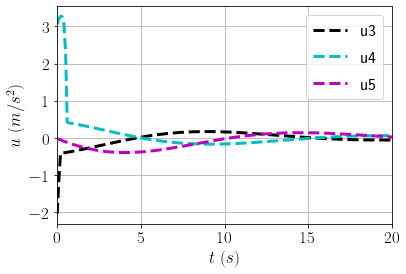

In [347]:
# Plot the control input (CBF-control)
fig6 = plt.figure()
ax6 = fig6.add_subplot(111)
ax6.plot(sol3.t, u3, 'k--', linewidth = 3, label = 'u3')
ax6.plot(sol4.t, u4, 'c--', linewidth = 3, label = 'u4')
ax6.plot(sol5.t, u5, 'm--', linewidth = 3, label = 'u5')
plt.xlim((0,20))
#plt.ylim((-2.5,4))
plt.xlabel('$t~(s)$', fontsize = 17)
plt.ylabel('$u~(m/s^2)$', fontsize = 17)
ax6.tick_params(labelsize = 17)
plt.grid(True)
plt.legend(fontsize = 17, loc = 1)
plt.savefig("CBF-control.png",bbox_inches='tight', pad_inches = 0.1)
plt.show()